In [9]:
import argparse
import time
import wandb
import datetime
import random
import sys
import os
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch
import copy
from os import path
import pandas as pd
from collections import Counter
from sklearn.metrics import accuracy_score
sys.path.append(os.path.abspath(os.path.join('..')))
from models.model_cae import model_cae
from models.sw_cls_cae_pretrained import sw_cls_cae_pretrained
from utility_functions.awe_dataset_class import awe_dataset_pre_computed_pre_training
from utility_functions.utils_function import (average_precision, collate_fn_pre_training)
import torch.nn.functional as F
from ast import literal_eval

In [11]:
torch.manual_seed(3112)
torch.cuda.manual_seed(3112)
torch.cuda.manual_seed_all(3112)
np.random.seed(3112)
random.seed(3112)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(3121)

In [12]:
bidirectional=True
batch_size=1
metadata_file="../data/hubert_features/hubert_feature_metadata.csv"

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
print("Is device CUDA:", device.type=="cuda")
if device.type == "cuda":
    num_workers = 4
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

print("number of workers:", num_workers)
print("pin memory status:", pin_memory)

Is device CUDA: False
number of workers: 0
pin memory status: False


In [15]:
train_data = awe_dataset_pre_computed_pre_training(
    feature_df=metadata_file,
    partition="train")

val_data = awe_dataset_pre_computed_pre_training(
    feature_df=metadata_file,
    partition="val"
)
test_data = awe_dataset_pre_computed_pre_training(
    feature_df=metadata_file,
    partition="test"
)

In [16]:
indices = np.random.choice(range(len(train_data)), 1000, replace=False)
train_data = torch.utils.data.Subset(train_data, indices)
indices = np.random.choice(range(len(val_data)), 1000, replace=False)
val_data = torch.utils.data.Subset(val_data, indices)
test_data = torch.utils.data.Subset(test_data, indices)

In [17]:
print("length of training data:",len(train_data))
print("length of validation data:",len(val_data))
print("length of test data:",len(test_data))

length of training data: 1000
length of validation data: 1000
length of test data: 1000


In [18]:
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn_pre_training,
    drop_last = False,
    num_workers=num_workers,
    pin_memory=pin_memory,
    worker_init_fn=seed_worker,
    generator=g
)
val_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn_pre_training,
    drop_last = False,
    num_workers=num_workers,
    pin_memory=pin_memory,
    worker_init_fn=seed_worker,
    generator=g
)
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn_pre_training,
    drop_last = False,
    num_workers=num_workers,
    pin_memory=pin_memory,
    worker_init_fn=seed_worker,
    generator=g
)

In [25]:
input_dim=768
hidden_dim=256
embedding_dim=128
rnn_type="GRU"
num_layers=4
dropout=0.2
model_weights1="../checkpoints/model_hubert/hubert_01/HUBERT_BASE_128_BEST.pt"
model_weights2="../checkpoints/model_subword_classification/sub_classification_01/HUBERT_BASE_128_BEST.pt"

In [26]:
filename = '../checkpoints/model_subword_classification/sub_classification_01/dict_tokens.pt'

dict_tokens = torch.load(filename)
classes = dict_tokens.keys()
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}
num_classes = len(dict_tokens)

In [63]:
## Define the pre-trained model
pre_model = model_cae(input_dim, hidden_dim, embedding_dim, 
                        rnn_type, bidirectional, num_layers, 
                        dropout)
# # print(pre_model)
# pre_model_checkpoint = torch.load(model_weights1, 
#                                   map_location=torch.device(device))
# # print(pre_model_checkpoint['model_state_dict'])
# pre_model.load_state_dict(pre_model_checkpoint['model_state_dict'])
# pre_model.eval()

# pre_model = pre_model.to(device)
# for param in pre_model.parameters():
#     param.requires_grad = False

## Define the model

model = sw_cls_cae_pretrained(hidden_dim, embedding_dim, rnn_type, 
                  bidirectional, num_layers, num_classes, dropout, 
                  pre_model.encoder)
model_checkpoint = torch.load(model_weights2, 
                                  map_location=torch.device(device))
model.load_state_dict(model_checkpoint['model_state_dict'])
model = model.to(device)
print(model)

sw_cls_cae_pretrained(
  (encoder): Encoder(
    (rnn_enc): GRU(768, 256, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True)
    (fc_enc): Linear(in_features=512, out_features=128, bias=True)
    (tanh): Tanh()
  )
  (attention): Attention(
    (attn): Linear(in_features=640, out_features=128, bias=True)
    (v): Linear(in_features=128, out_features=1, bias=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=640, out_features=128, bias=True)
      (v): Linear(in_features=128, out_features=1, bias=False)
    )
    (embedding): Embedding(188, 128)
    (rnn): GRU(640, 128)
    (fc_out): Linear(in_features=768, out_features=188, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
)


In [64]:
params = list(model.parameters())
# check gradient is False or not
# for param in params:
#     print(param.requires_grad)

In [65]:
cumu = 0
for layer in params:
    cumu += layer.numel()

print("Total number of parameters:", cumu)

Total number of parameters: 5736252


In [66]:
def doop(l):
  return ''.join(l)

In [67]:
def evaluate_accuracy(model, data_loader, device, max_length=12):
    model.eval()
    EOW_token = 1
    y_true = []
    y_pred = []
    attention_list = []
    for idx, (data,lens,word_name,_,token,token_len) in enumerate(data_loader):
        # print(idx)
        # for m in range(len(token)):
        #     for subword in range(len(token[m])):
        #         token[m][subword] = class_to_idx[token[m][subword]]
        #     token[m] = torch.tensor(token[m])
        # token = torch.utils.pad_sequence(token, batch_first=True, padding_value=class_to_idx['PAD'])
        token = torch.from_numpy(np.vectorize(class_to_idx.get)(token))
        data, lens, token = data.to(device), lens.to(device), token.to(device)
        if  device.type == 'cuda()':
            # print("cuda")
            word_name = word_name.cpu()
        # else:
        #     # print("cpu")
        with torch.no_grad():
            encoder_outputs, encoded_x = model.encoder(data, lens)
            # encoded_x = model.scale_encoder(encoded_x)

        decoded_subwords = []
        # decoder_attentions = torch.zeros(max_length, max_length)

        # batch_size = token.size(0)
        trg = token.T # [token len, batch size]
        # trg_len = trg.size(0) # [token_len]
        input = trg[0,:] # [batch_size,1,1]
        hidden = encoded_x # [1, batch_size,embedding_dim/hidden dim]
        mask = model.create_mask(data)
        attentions = torch.zeros(max_length, 1, lens).to(device)
        for di in range(1,max_length):
            output, hidden, attention = model.decoder(
                input, hidden, encoder_outputs, mask)
            attentions[di] = attention
            top1 = output.argmax(1)
            if top1.item()==EOW_token:
                # print("detected end of word token")
                decoded_subwords.append([idx_to_class[index.item()].replace("▁","").replace("EOW","").upper() for index in top1])
                break
            else:
                decoded_subwords.append([idx_to_class[index.item()].replace("▁","").replace("EOW","").upper() for index in top1])
            input = top1.detach()
        decoded_words = np.apply_along_axis(doop, 0, np.array(decoded_subwords))
        # print(di, decoded_words)
        y_true = y_true + list(word_name)
        y_pred = y_pred + decoded_words.tolist()
        # attention_list = attention_list.append(attention)
        # if idx%1==0:
        #     print(idx)
        #     return y_true, y_pred, attentions
        #     break

    accuracy = accuracy_score(y_true,y_pred)
    print("accuracy", accuracy)

    return accuracy,attention_list

In [68]:
train_accuracy = evaluate_accuracy(model, train_loader, device)
print("train_accuracy", train_accuracy)
val_accuracy = evaluate_accuracy(model, val_loader, device)
print("val_accuracy", val_accuracy)
test_accuracy = evaluate_accuracy(model, test_loader, device)
print("test_accuracy", test_accuracy)

accuracy 0.996
train_accuracy (0.996, [])
accuracy 0.883
val_accuracy (0.883, [])
accuracy 0.889
test_accuracy (0.889, [])


In [120]:
# def evaluate2(model, data, lens, word_name, token, device, max_length=12):
#     model.eval()
#     EOW_token = 1
#     token = torch.from_numpy(np.vectorize(class_to_idx.get)(token))
#     data, lens, token = data.to(device), lens.to(device), token.to(device)
#     word_name = word_name ## .cpu()
#     with torch.no_grad():
#         encoder_outputs, encoded_x = model.encoder(data, lens)
#         encoded_x = model.scale_encoder(encoded_x)

#     decoded_subwords = []
#     trg = token.T # [token len, batch size]
#     # trg_len = trg.size(0) # [token_len]
#     input = trg[0,:] # [batch_size,1,1]
#     hidden = encoded_x # [1, batch_size,embedding_dim/hidden dim]
#     mask = model.create_mask(data)
#     attentions = torch.zeros(max_length, 1, lens).to(device)
#     for di in range(1,max_length):
#         output, hidden, attention,_ = model.decoderV(
#             input, hidden, encoder_outputs, mask,torch.tensor([di-1]))
#         attentions[di] = attention
#         top1 = output.argmax(1)
#         if top1.item()==EOW_token:
#             # print("detected end of word token")
#             decoded_subwords.append([idx_to_class[index.item()] for index in top1])
#             break
#         else:
#             decoded_subwords.append([idx_to_class[index.item()] for index in top1])
#         input = top1.detach()
        
#     return decoded_subwords, attentions

In [47]:
def evaluate_attn(model, data, lens, word_name, token, device, max_length=11):
    model.eval()
    EOW_token = 1
    SOW_token = 0
    token = torch.from_numpy(np.vectorize(class_to_idx.get)(token))
    data, lens, token = data.to(device), lens.to(device), token.to(device)
    # print(len(token))
    if  device.type == 'cuda()':
        # print("cuda")
        word_name = word_name.cpu()
    # else:
    #     print("cpu")
    with torch.no_grad():
        encoder_outputs, encoded_x = model.encoder(data, lens)
        # encoded_x = model.scale_encoder(encoded_x)
    mask = model.create_mask(data)
    trg_indexes = [SOW_token]


    hidden = encoded_x # [1, batch_size,embedding_dim/hidden dim]
    
    attentions = torch.zeros(max_length, 1, lens).to(device)

    for di in range(max_length):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        output, hidden, attention = model.decoder(
            trg_tensor, hidden, encoder_outputs, mask)
        attentions[di] = attention
        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)
        if pred_token == EOW_token:
            break

    trg_tokens = [idx_to_class[i] for i in trg_indexes]
        
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

In [58]:
for idx, (data,lens,word_name,_,token,token_len) in enumerate(val_loader):
    a,b = evaluate_attn(model, data, lens, word_name, token, device)
    if idx==0:
        break

In [59]:
print(a,b.shape,word_name)

['he', 'ther', 'ther', 's', 'EOW'] torch.Size([5, 1, 35]) ['OTHERS']


In [60]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [61]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    
    x_ticks = [''] + ['<sow>'] + [t.lower() for t in sentence] + ['<eow>']
    y_ticks = [''] + translation
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()


/tmp/ipykernel_21070/882002334.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
/tmp/ipykernel_21070/882002334.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


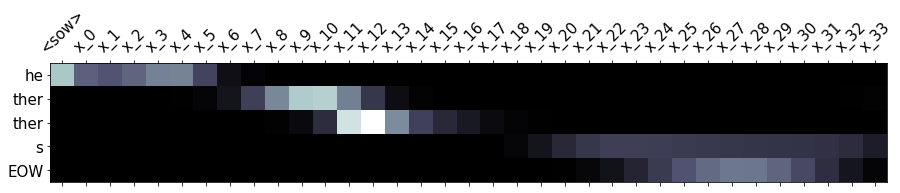

In [62]:
sentence = ["x_" + str(i) for i in range(b.shape[2])]
display_attention(sentence,a, b)

In [25]:
# dict_sub_emb = {p : [] for p in range(10)}
# dict_sub_emb_id = {p : [] for p in range(10)}
# for idx, (data,lens,word_name,_,token,token_len) in enumerate(test_loader):
#     trg_tokens,_,sub_emb = evaluate_attn(model, data, lens, word_name, token, device)
#     # token = token[0][1:-1] # remove start and end of word token
#     # note: can't use token because it is not the same as the token predicted by the model, which is trg_tokens, can have differnt length
#     for i in range(len(trg_tokens)-1):    # -1 because we don't want to include the end of word token as a subword
#         dict_sub_emb[i].append(sub_emb[i].detach())
#         dict_sub_emb_id[i].append(class_to_idx[trg_tokens[i]])
#     if idx==5000:
#         print(idx)
#         break

In [143]:
dict_sub_emb = {p : [] for p in range(10)}
dict_sub_emb_id = {p : [] for p in range(10)}
count = 0
for idx, (data,lens,word_name,_,token,token_len) in enumerate(test_loader):
    trg_tokens,_,sub_emb = evaluate_attn(model, data, lens, word_name, token, device)
    trg_tokens = trg_tokens[:-1] # -1 because we don't want to include the end of word token as a subword
    token = token[0][1:-1] # 1, -1 because we don't want to include the start and end of word token as a subword
    if ''.join(trg_tokens) != ''.join(token):
        print(''.join(trg_tokens), ''.join(token), 'different')
        count += 1
    else:   
        print(''.join(trg_tokens), ''.join(token), 'same')
        for i in range(len(trg_tokens)):    
            dict_sub_emb[i].append(sub_emb[i].detach())
            dict_sub_emb_id[i].append(class_to_idx[trg_tokens[i]])
        if idx%100==0:
            print(idx)
            break
print(count)

marlanx marlanx same
0
0


In [142]:
idx

714

In [137]:
''.join(trg_tokens[:-1])

'oswald'

In [136]:
''.join(token[0][1:-1])

'oswald'

In [ ]:
len(dict_sub_emb[2])

In [ ]:
len(dict_sub_emb_id[2])

In [ ]:
embs = torch.cat(dict_sub_emb[1],0).to(torch.float16).numpy()
ids = np.array(dict_sub_emb_id[1])
avg_precision,_ = average_precision(embs, ids, "cosine", show_plot=False)

In [ ]:
avg_precision

In [ ]:
embs = torch.cat(dict_sub_emb[10],0).to(torch.float16).numpy()
ids = np.array(dict_sub_emb_id[10])
avg_precision,_ = average_precision(embs, ids, "cosine", show_plot=False)

In [ ]:
type(embs)

In [ ]:
ids

In [ ]:
test_avg_precision = []
for i in range(len(dict_sub_emb)):
    embs = torch.cat(dict_sub_emb[i],0).to(torch.float16).numpy()
    ids = np.array(dict_sub_emb_id[i])
    avg_precision,_ = average_precision(embs, ids, "cosine", show_plot=False)
    test_avg_precision.append(avg_precision)
    print("average precision for subword at position {} is {}".format(i,avg_precision))

print("average precision for all subwords is {}".format(np.mean(test_avg_precision)))



# sub_embeddings, ids = torch.cat(dict_sub_emb[0],0).to(torch.float16).numpy(), np.array(dict_sub_emb_id[0])

In [163]:
# # create dictoinary of dictionary with position as key and value as list of subword embeddings
# dict_pos = {p : {} for p in range(10)}
# dict_pos_count = {p : {} for p in range(10)}
# for idx, (data,lens,word_name,_,token,token_len) in enumerate(train_loader):
#     a,b,c = evaluate_attn(model, data, lens, word_name, token, device)
#     a = a[:-1] # remove <eow> token
#     token = token[0][1:] # remove <sow> token
#     for i in range(len(a)):
#         if a[i] not in dict_pos[i]:
#             dict_pos[i][a[i]] = c[i]
#             dict_pos_count[i][a[i]] = 1
#         else:
#             dict_pos[i][a[i]] += c[i]
#             dict_pos_count[i][a[i]] += 1
#     if idx==1000:        
#         print(idx)
#         break

1000


In [144]:
# create dictoinary of dictionary with position as key and value as list of subword embeddings
dict_pos = {p : {} for p in range(10)}
dict_pos_count = {p : {} for p in range(10)}
for idx, (data,lens,word_name,_,token,token_len) in enumerate(train_loader):
    trg_tokens,b,c = evaluate_attn(model, data, lens, word_name, token, device)
    trg_tokens = trg_tokens[:-1] # remove <eow> token
    c = c[:-1] # remove <eow> token
    token = token[0][1:-1] # remove <sow> token
    if ''.join(trg_tokens) != ''.join(token):
        print(''.join(trg_tokens), ''.join(token), 'different')
    else:   
        print(''.join(trg_tokens), ''.join(token), 'same')

        for i in range(len(trg_tokens)):    
            if trg_tokens[i] not in dict_pos[i]:
                dict_pos[i][trg_tokens[i]] = c[i]
                dict_pos_count[i][trg_tokens[i]] = 1
            else:
                dict_pos[i][trg_tokens[i]] += c[i]
                dict_pos_count[i][trg_tokens[i]] += 1
        if idx==100:        
            print(idx)
            break

telegraph telegraph same
accusations accusations same
proportionately proportionately same
perfect perfect same
acknowledging acknowledging same
starfish starfish same
seldom seldom same
grandfather grandfather same
apopologize apologize different
combatants combatants same
seclusion seclusion same
foretold foretold same
intermediate intermediate same
solicited solicited same
talker talker same
archipelago archipelago same
incompparable incomparable different
terriers terriers same
contradictcted contradicted different
correspondent correspondent same
thorns thorns same
foot foot same
crude crude same
currants currants same
honestly honestly same
tarzan tarzan same
perverse perverse same
favourite favourite same
fairies fairies same
needful needful same
objective objective same
rather rather same
enveloped enveloped same
worthiness worthiness same
delegates delegates same
fraser fraser same
scaffold scaffold same
concentrate concentrate same
symbol symbol same
unconciousousnessous unco

In [147]:
trg_tokens

['j', 'u', 'li', 'et']

In [151]:
c[:-1].shape

torch.Size([4, 1, 128])

In [159]:
token

array(['to', 'r', 't', 'u', 'res', 'EOW'], dtype=object)

In [160]:
a

['to', 'r', 't', 'u', 'res', 'EOW']

In [ ]:
# take the averratge of all the subword embeddings base on the position dictionary count
for i in range(len(dict_pos)):
    for key in dict_pos[i]:
        dict_pos[i][key] = F.normalize(dict_pos[i][key]/dict_pos_count[i][key])

In [ ]:
torch.norm(dict_pos[5]['EOW'])

In [3]:
## get the list of words in the test set that are not in the train set
## after that, generate and cacluate AP-CW
# test_words = []
# for idx, (data,lens,word_name,_,token,token_len) in enumerate(test_loader):
#     test_words.extend(word_name)

df_train = pd.read_csv("../e2e_subword_embedding_1/data_final_7000/train.csv")
df_test = pd.read_csv("../e2e_subword_embedding_1/data_final_7000/test.csv")
df_val = pd.read_csv("../e2e_subword_embedding_1/data_final_7000/val.csv")

In [153]:
filename= "dict_pos.pt"
if os.path.exists(filename):
    dict_pos = torch.load(filename)

In [154]:
df_test.head()

,filename,flag,start,duration,word,tokenized,count_tokens,sp_id_and_ch_id,filename_path
0,LSP-140711-0008_1,1,5.46,0.66,JERVIS,"['j', 'er', 'v', 'is']",4,-140711-0008,./train-other-500/3587/140711/3587-140711-0008...
1,LSP-132570-0000_1,1,1.59,0.64,DISPUTING,"['d', 'is', 'p', 'ut', 'ing']",5,-132570-0000,./train-clean-100/2007/132570/2007-132570-0000...
2,LSP-5059-0002_1,1,3.96,0.94,SATISFACTORILY,"['s', 'at', 'is', 'f', 'ac', 'to', 'ri', 'ly']",8,-5059-0002,./train-other-500/2930/5059/2930-5059-0002.flac
3,LSP-172162-0032_1,1,5.33,0.81,UNOCCUPIED,"['u', 'no', 'c', 'c', 'up', 'i', 'ed']",7,-172162-0032,./train-clean-100/3436/172162/3436-172162-0032...
4,LSP-287660-0003_1,1,8.25,0.56,TESTIFIED,"['t', 'est', 'if', 'i', 'ed']",5,-287660-0003,./train-clean-360/8506/287660/8506-287660-0003...


In [155]:
unique_word_train = df_train['word'].unique()
print(len(unique_word_train))

6799


In [156]:
unique_word_test = df_test['word'].unique()
print(len(unique_word_test))

5364


In [157]:
set_train = set(unique_word_train)
set_test = set(unique_word_test)
not_common = set_test - set_train

In [158]:
len(not_common)

141

In [4]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer
tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
tokenizer.pre_tokenizer = Whitespace()
tokenizer = Tokenizer.from_file("../tokenizer-bpe200.json")
df_test_emb = torch.load("../paper2/embeddings_final/test_emb_norm.pt")
df_test = pd.read_csv("../paper2/embeddings_final/test_emb.csv", converters={'tokenized': literal_eval})

In [8]:
df_test_emb

tensor([[ 0.0754,  0.0947, -0.1163,  ...,  0.1009,  0.1055,  0.0906],
        [ 0.1224,  0.0887, -0.1109,  ..., -0.0439,  0.0095, -0.0928],
        [ 0.1198,  0.0781, -0.1141,  ..., -0.0280,  0.0867,  0.0907],
        ...,
        [ 0.1077,  0.0913, -0.1331,  ...,  0.0783, -0.1260, -0.1049],
        [ 0.1180, -0.0548, -0.1337,  ..., -0.0490, -0.1388,  0.0196],
        [-0.0450,  0.1079, -0.1352,  ...,  0.0050, -0.0254, -0.0924]])

In [9]:
df_test['ids'].values

array([5031, 3105, 5028, ..., 4664, 1815, 2215])

In [10]:
sub_embeddings = df_test_emb
ids = df_test['ids'].values
test_avg_precision,_ = average_precision(sub_embeddings.cpu(),ids, "cosine",show_plot=False)
print("average precision on test set words - AP :", test_avg_precision)

average precision on test set - AP-SD : 0.9577458207536054


In [160]:
# len(df_test[df_test['count_tokens']==11]['word'].unique())

In [161]:
df_test.head()

,unique_id,words,ids,tokenized
0,1182-134981-0042,UNCONTROLLABLE,5031,"[un, con, t, ro, ll, ab, le]"
1,296-142727-0013,MOSQUITOES,3105,"[mo, s, qu, i, to, es]"
2,1740-141148-0078,UNCOMPROMISING,5028,"[un, com, p, rom, is, ing]"
3,1695-142312-0079,CONSISTENCY,982,"[con, s, is, t, en, c, y]"
4,8799-270794-0014,INDIRECTLY,2468,"[ind, i, re, ct, ly]"


In [162]:
len(df_test['tokenized'])

14090

In [163]:
df_test[df_test['tokenized'].str.len()==3]

,unique_id,words,ids,tokenized
6,4345-7635-0040,HOUNDS,2329,"[h, ound, s]"
23,4396-14564-0020,TILES,4887,"[t, il, es]"
30,2380-152158-0076,INHERENT,2518,"[in, her, ent]"
57,1924-132576-0011,HOLLAND,2288,"[ho, ll, and]"
59,7011-66622-0040,BEANS,411,"[be, an, s]"
...,...,...,...,...
14069,441-128982-0030,REMOVE,4014,"[re, mo, ve]"
14070,1746-143015-0024,BORNE,548,"[b, or, ne]"
14074,7285-72200-0018,JAIL,2621,"[j, a, il]"
14079,2751-142363-0039,FOGG,1857,"[fo, g, g]"


In [176]:
shuffle_pos = "no"
# unique_words = df_test[df_test['tokenized'].str.len()==3]['words'].unique()
unique_words = df_test['words'].unique()
print("total unique words in test set",len(unique_words))

artificial_words = np.zeros(shape=(len(unique_words),128)) ## embedding dim is input_dim  here

if shuffle_pos =="no":
    flag = [True]*len(unique_words)
    for i, w in enumerate(unique_words):
        bpe_list = tokenizer.encode(w.lower()).tokens
        sum_emb = torch.zeros(1,128)
        for j in range(len(bpe_list)):
            if bpe_list[j] in dict_pos[j]:
                sum_emb += dict_pos[j][bpe_list[j]].detach()
            else:
                flag[i] = False
                print("not found",bpe_list[j])
                break
        artificial_words[i] = torch.tanh(model.proj_layer(sum_emb)).detach().numpy()
    artificial_words = F.normalize(torch.from_numpy(artificial_words)).numpy()
    artificial_words = artificial_words[flag]
    unique_words = unique_words[flag]
    print("total unique words in test set",len(unique_words))
    lista = unique_words
    listb = df_test["words"].values

    labels = []
    for i in lista:
        for j in listb:
            if i==j:
                labels.append(True)
            else:
                labels.append(False)
    ap_rw, _ = metric2(artificial_words, df_test_emb, np.array(labels), "cosine") ## calculate df_test_emb befoer hand

    print("Average precision for reconstructed words (AP-CW):", ap_rw)


# else:
#     flag = []
#     for i, w in enumerate(unique_words):
#         index = df_test_metadata[df_test_metadata["words"] == w].index[0]
#         bpe_list = df_test_metadata.iloc[index,3]

#         if bpe_list[1] in list_sub_words3 and bpe_list[2] in list_sub_words2:
#             sum_emb = sub_word_dict1[bpe_list[0]] + sub_word_dict3[bpe_list[1]] + sub_word_dict2[bpe_list[2]]
#             flag.append(True)
#         else: 
#             sum_emb = np.zeros((1,128))
#             flag.append(False)

#         if args.model_name=="fact_net3":
#             sum_emb = torch.from_numpy(sum_emb)
#             artificial_words[i] = torch.tanh(model.fc_projection(sum_emb.float())).detach().numpy()
#         else:
#             artificial_words[i] = sum_emb

#     if args.norm=="True":
#         artificial_words = F.normalize(torch.from_numpy(artificial_words)).numpy()

#     artificial_words = artificial_words[flag]
#     unique_words = unique_words[flag]

#     lista = unique_words
#     listb = df_test_metadata["words"].values

#     labels = []
#     for i in lista:
#         for j in listb:
#             if i==j:
#                 labels.append(True)
#             else:
#                 labels.append(False)
#     test_metric2, _ = metric2(artificial_words, df_test_emb, np.array(labels), args.distance)

    # print("Average precision for reconstructed words (AP-RW) for swapped pos 2 and 3:", test_metric2)

total unique words in test set 5364
not found rom
not found ard
not found x
not found to
not found ke
not found it
not found if
not found ard
not found ast
not found ing
not found ri
not found d
not found ur
not found lo
not found j
not found [UNK]
not found it
not found ast
not found b
not found ac
not found up
total unique words in test set 5343
Average precision for reconstructed words (AP-CW): 0.0009852214374123417


In [175]:
torch.norm(torch.tensor(artificial_words[0]))

tensor(1.0000, dtype=torch.float64)

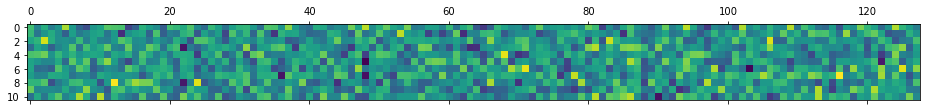

In [180]:
plt.matshow(model.decoderV.pos_embedding.weight.detach().numpy())

In [166]:
torch.norm(dict_pos[0]['a'])

tensor(1.0000, grad_fn=<CopyBackwards>)

In [121]:
lista

array(['UNCONTROLLABLE', 'MOSQUITOES', 'UNCOMPROMISING', ..., 'BRUSH',
       'COLOR', 'FOLLY'], dtype=object)

In [111]:
df_test_emb.shape

torch.Size([14090, 128])

In [57]:
sum(labels)

14064

In [58]:
len(labels)

75466040

In [136]:
lens = torch.tensor([7,3,4,5])
mask = torch.repeat_interleave(torch.ones(4,768), lens, dim=0, output_size=sum(lens))
mask = torch.split(mask, lens.tolist())
mask_padded = torch.nn.utils.rnn.pad_sequence(mask, batch_first=False)

In [137]:
mask_padded.shape

torch.Size([7, 4, 768])

In [138]:
mask_padded[3,1,:]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [132]:
lens[1:-1]

tensor([1, 2])